In [163]:
import importlib 
import plot_utils
import domain_objects
import calculator

importlib.reload(plot_utils)
importlib.reload(domain_objects)
importlib.reload(calculator)

<module 'calculator' from 'C:\\Users\\juszynski\\Desktop\\wspace\\coordinating-quantifiers\\v2\\calculator.py'>

In [164]:
import json
import numpy as np
from domain_objects import GameParams, NewAgent
from new_guessing_game import RandomFunctions, run_simulation, new_random_f, select_speaker, select_hearer, avg_series
from calculator import NumericCalculator, QuotientCalculator


In [165]:
population_size=10
stimulus='quotient'
max_num=100
discriminative_threshold=0.95
discriminative_history_length=50
delta_inc=0.2
delta_dec=0.2
delta_inh=0.2
alpha=0.001
super_alpha=0.01
beta=0.2
steps=2100
runs=1
guessing_game_2=False
seed=0

params = GameParams(population_size=population_size,
               stimulus=stimulus,
               max_num=max_num,
               discriminative_threshold=discriminative_threshold,
               discriminative_history_length=50,
               delta_inc=delta_inc,
               delta_dec=delta_dec,
               delta_inh=delta_inh,
               alpha=alpha,
               super_alpha=super_alpha,
               beta=beta,
               steps=steps,
               runs=runs,
               guessing_game_2=guessing_game_2,
               seed=seed)


In [166]:
r = next(new_random_f(seed=params.seed))
agg_cs1 = []
agg_ds = []
calculator = {'numeric': NumericCalculator.load_from_file(),
                  'quotient': QuotientCalculator.load_from_file()}[params.stimulus]
population, states_sequences, states_edges_cnts, states_cnts = run_simulation(calculator, params, r.shuffle_list_random_function(), r.flip_a_coin_random_function(), r.pick_element_random_function())

windowed_communicative_success1 = np.array([avg_series(a.get_communicative_success1()) for a in population])*100
windowed_communicative_success2 = [avg_series(a.get_communicative_success2()) for a in population]
windowed_discriminative_success = np.array([avg_series(a.get_discriminative_success()) for a in population])*100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2100/2100 [00:23<00:00, 90.56it/s]


In [167]:
averaged_windowed_communicative_success1 = np.mean(windowed_communicative_success1, axis=0)
averaged_windowed_discriminative_success = np.mean(windowed_discriminative_success, axis=0)

# Analysis & Visualizations

## Single Agent Analysis

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook
from plot_utils import bokeh_plot_category, plot_category


In [169]:
agent = population[0]
meanings = agent.compute_word_meanings()   

word, activations = list(meanings.items())[2]
values = calculator.values()
stimuli_meaning = np.array(values)[activations]
most_connected_category = agent.get_most_connected_category(word)
most_connected_category_pdf = most_connected_category.discretized_distribution(calculator)

stimuli_meaning = [float(v) for v in stimuli_meaning]
figure = plot_utils.bokeh_plot_category(most_connected_category, calculator.domain(), most_connected_category_pdf, stimuli_meaning)

output_notebook()
show(figure)

Loading BokehJS ...

In [170]:
agent = population[0]
word2pragmatic_meaning = agent.compute_word_pragmatic_meanings()   

word, pragmatic_meaning = list(meanings.items())[0]
values = calculator.values()

most_connected_category = agent.get_most_connected_category(word)
most_connected_category_pdf = most_connected_category.discretized_distribution(calculator)

stimuli_meaning = [float(v) for v in pragmatic_meaning]
figure = plot_utils.bokeh_plot_category(most_connected_category, calculator.domain(), most_connected_category_pdf, stimuli_meaning)

output_notebook()
show(figure)

Loading BokehJS ...

In [172]:
agent = population[0]
recreated_agent_snapshots = NewAgent.recreate_from_history(agent_id=agent.agent_id, calculator=calculator, game_params=params, updates_history=agent.updates_history)

recreating agent 8 by updates: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2100/2100 [00:01<00:00, 1675.13it/s]


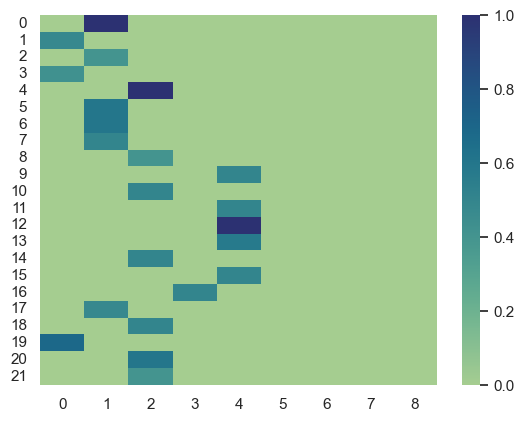

In [175]:
step, snapshot = recreated_agent_snapshots[10]
agent_dict = NewAgent.to_dict(snapshot)
lxc = np.array(agent_dict['lxc'])

sns.set()
ax = sns.heatmap(lxc, vmin=0, vmax=1, cmap="crest")
plt.show()

## Population Statistics

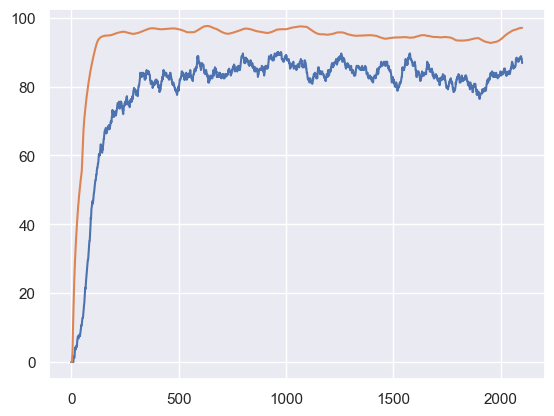

In [158]:
plt.plot(range(len(averaged_windowed_communicative_success1)), averaged_windowed_communicative_success1)
plt.plot(range(len(averaged_windowed_discriminative_success)), averaged_windowed_discriminative_success)

plt.show()


In [176]:
population_snapshots = [NewAgent.recreate_from_history(agent_id=a.agent_id, calculator=calculator, game_params=params, updates_history=a.updates_history)for a in population]

recreating agent 2 by updates: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2100/2100 [00:01<00:00, 1536.78it/s]


In [177]:
population_active_lexicon = [[len(snap.get_words()) for step, snap in history] for history in population_snapshots]
snapshot_steps = [step for step, h in population_snapshots[0]]

In [178]:
mean_lexicon_size = np.mean(np.array(population_active_lexicon), axis=0)
lexicon_size = [*zip(snapshot_steps, mean_lexicon_size)]

In [179]:
from bokeh.plotting import figure

fig = figure(title='Success Rate', x_axis_label='Steps')
steps_range = [*range(steps)]
fig.line(steps_range, averaged_windowed_discriminative_success, legend_label='discriminative success', line_width=.5, color='red')
fig.line(steps_range, averaged_windowed_communicative_success1, legend_label='communicative success 1', line_width=.5, color='green')
fig.line(snapshot_steps, mean_lexicon_size, legend_label='lexicon size', line_width=.5, color='blue')

output_notebook()
show(fig)


Loading BokehJS ...